In [1]:
import pandas as pd
dataset = pd.read_csv("/content/preprocessed_news_article_removing_numbers(1).csv")

In [2]:
text = dataset['Text']
category = dataset['Category']
text.head()

,Text
0,গ্যাটকো দুর্নীতি মামলায় বিএনপি চেয়ারপারসন খালে...
1,সৈয়দ এম ওমর তৈয়ব প্রাইম ব্যাংক উপব্যবস্থাপনা প...
2,প্রধান নির্বাচন কমিশন সিইসি কেএম নূরুল হুদ উদ্...
3,আওয়ামী লীগ সম্পাদক সড়ক পরিবহন সেতুমন্ত্রী ওব...
4,সোহেল তাজ আস দরজায় রেডি চলতি বছর এপ্রিলে খবরে ...


In [3]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import random
from sklearn.model_selection import train_test_split


np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set for use")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. Running on CPU.")


X_train, X_test, Y_train, Y_test = train_test_split(text, category, test_size=0.2, random_state=42)


label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


max_features = 30000
max_len = 399

tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=max_features, ngram_range=(1,2))),
    ('svm', SVC(kernel='rbf', probability=True, C=1.0, gamma='scale'))
])
svm.fit(X_train, Y_train_encoded)

with tf.device('/GPU:0'):
    embedding_dims = 300
    hidden_dims = 128
    batch_size = 128
    epochs = 100
    num_classes = len(np.unique(Y_train_encoded))

    lstm_model = Sequential([
        Embedding(max_features, embedding_dims, input_length=max_len),
        Bidirectional(LSTM(hidden_dims, return_sequences=True)),
        Bidirectional(LSTM(hidden_dims // 2, return_sequences=True)),
        GlobalMaxPooling1D(),
        Dense(hidden_dims, activation='relu'),
        Dropout(0.5),
        Dense(hidden_dims // 2, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


lstm_history = lstm_model.fit(
    X_train_padded, Y_train_encoded,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

class KerasClassifierWrapper:
    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
        self.keras_model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

    def predict(self, X):
        return np.argmax(self.keras_model.predict(X), axis=1)

lstm = KerasClassifierWrapper(lstm_model)


svm_predictions_train = svm.predict_proba(X_train)
lstm_predictions_train = lstm_model.predict(X_train_padded)

meta_features_train = np.concatenate([svm_predictions_train, lstm_predictions_train], axis=1)

svm_predictions_test = svm.predict_proba(X_test)
lstm_predictions_test = lstm_model.predict(X_test_padded)

meta_features_test = np.concatenate([svm_predictions_test, lstm_predictions_test], axis=1)


with tf.device('/GPU:0'):
    meta_model = Sequential([
        Dense(256, input_dim=meta_features_train.shape[1], activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    meta_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


early_stopping_meta = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_meta = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


meta_history = meta_model.fit(
    meta_features_train,
    Y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping_meta, reduce_lr_meta],
    verbose=1
)



GPU is available and set for use
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


593/593 ━━━━━━━━━━━━━━━━━━━━ 141s 233ms/step - accuracy: 0.6469 - loss: 0.9939 - val_accuracy: 0.9259 - val_loss: 0.2473 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 137s 231ms/step - accuracy: 0.9366 - loss: 0.2285 - val_accuracy: 0.9342 - val_loss: 0.2319 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 138s 232ms/step - accuracy: 0.9651 - loss: 0.1300 - val_accuracy: 0.9265 - val_loss: 0.2966 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 138s 232ms/step - accuracy: 0.9736 - loss: 0.0910 - val_accuracy: 0.9222 - val_loss: 0.3421 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 137s 231ms/step - accuracy: 0.9834 - loss: 0.0592 - val_accuracy: 0.9338 - val_loss: 0.3122 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 134s 226ms/step - accuracy: 0.9908 - loss: 0.0328 - val_accuracy: 0.9367 - val_loss: 0.3557 - learning_rate: 2.0000e-04
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 106s 178ms/step - accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


593/593 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9300 - loss: 0.3812 - val_accuracy: 0.9722 - val_loss: 0.1195 - learning_rate: 0.0010
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9854 - loss: 0.0739 - val_accuracy: 0.9736 - val_loss: 0.1104 - learning_rate: 0.0010
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9853 - loss: 0.0675 - val_accuracy: 0.9721 - val_loss: 0.1142 - learning_rate: 0.0010
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9856 - loss: 0.0671 - val_accuracy: 0.9722 - val_loss: 0.1094 - learning_rate: 0.0010
Epoch 5/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9850 - loss: 0.0654 - val_accuracy: 0.9740 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 6/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9858 - loss: 0.0627 - val_accuracy: 0.9734 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 7/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9859 - loss: 0.0616 - val

In [4]:

meta_predictions = np.argmax(meta_model.predict(meta_features_test), axis=1)


test_accuracy = round(accuracy_score(meta_predictions, Y_test_encoded) * 100, 2)
print(f"Stacking Classifier Test Accuracy Score: {test_accuracy}%")
print(classification_report(meta_predictions, Y_test_encoded, target_names=label_encoder.classes_))


print(f"LSTM model trained for {len(lstm_history.history['loss'])} epochs")
print(f"Meta-model trained for {len(meta_history.history['loss'])} epochs")

741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Stacking Classifier Test Accuracy Score: 93.84%
               precision    recall  f1-score   support

      economy       0.93      0.92      0.93      3718
    education       0.95      0.93      0.94      2629
entertainment       0.97      0.95      0.96      3441
international       0.94      0.94      0.94      3122
     politics       0.96      0.96      0.96      2632
       sports       0.99      0.99      0.99      3306
        state       0.88      0.90      0.89      2956
   technology       0.89      0.91      0.90      1877

     accuracy                           0.94     23681
    macro avg       0.94      0.94      0.94     23681
 weighted avg       0.94      0.94      0.94     23681

LSTM model trained for 7 epochs
Meta-model trained for 42 epochs


741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<ipython-input-7-72e53ab55b70>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))


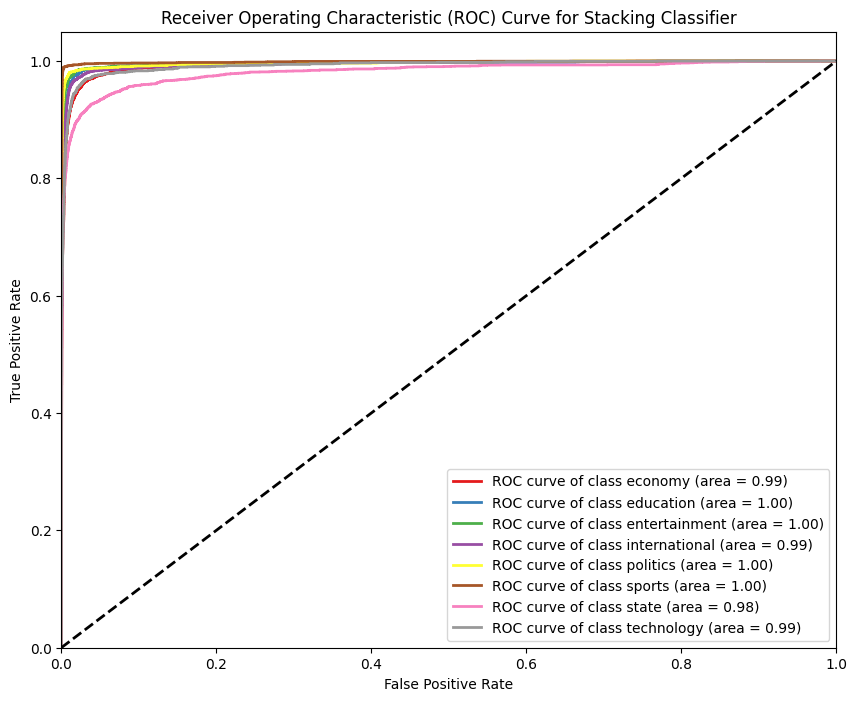

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_pred_proba = meta_model.predict(meta_features_test)

y_test_bin = label_binarize(Y_test_encoded, classes=np.arange(len(label_encoder.classes_)))


fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Stacking Classifier')
plt.legend(loc="lower right")
plt.show()

741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


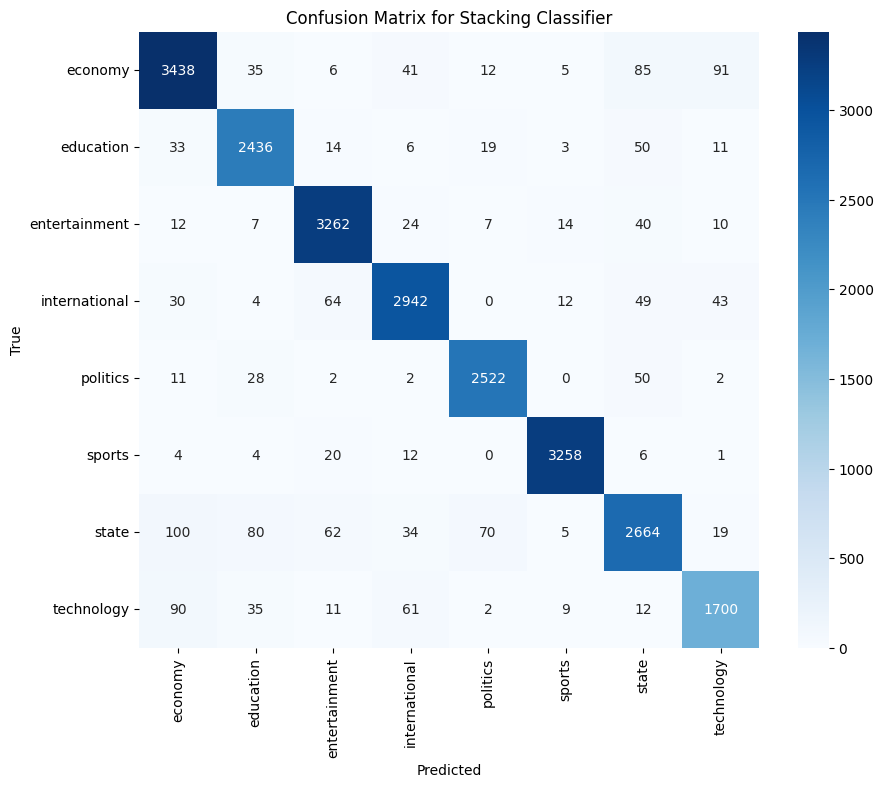

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have these variables from your previous code
# meta_model, meta_features_test, Y_test_encoded, label_encoder

# Get predictions
meta_predictions = np.argmax(meta_model.predict(meta_features_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_test_encoded, meta_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Stacking Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()